In [7]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [10]:
train_x = torch.linspace(0, 1, 10)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi)))

In [11]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
# likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [12]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.numel())

training_iter = 50
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.908
Iter 2/50 - Loss: 0.840
Iter 3/50 - Loss: 0.797
Iter 4/50 - Loss: 0.790
Iter 5/50 - Loss: 0.787
Iter 6/50 - Loss: 0.780
Iter 7/50 - Loss: 0.774
Iter 8/50 - Loss: 0.768
Iter 9/50 - Loss: 0.764
Iter 10/50 - Loss: 0.759
Iter 11/50 - Loss: 0.752
Iter 12/50 - Loss: 0.746
Iter 13/50 - Loss: 0.742
Iter 14/50 - Loss: 0.739
Iter 15/50 - Loss: 0.738
Iter 16/50 - Loss: 0.735
Iter 17/50 - Loss: 0.731
Iter 18/50 - Loss: 0.727
Iter 19/50 - Loss: 0.725
Iter 20/50 - Loss: 0.723
Iter 21/50 - Loss: 0.721
Iter 22/50 - Loss: 0.719
Iter 23/50 - Loss: 0.716
Iter 24/50 - Loss: 0.714
Iter 25/50 - Loss: 0.712
Iter 26/50 - Loss: 0.710
Iter 27/50 - Loss: 0.709
Iter 28/50 - Loss: 0.707
Iter 29/50 - Loss: 0.705
Iter 30/50 - Loss: 0.703
Iter 31/50 - Loss: 0.702
Iter 32/50 - Loss: 0.701
Iter 33/50 - Loss: 0.699
Iter 34/50 - Loss: 0.698
Iter 35/50 - Loss: 0.697
Iter 36/50 - Loss: 0.696
Iter 37/50 - Loss: 0.695
Iter 38/50 - Loss: 0.694
Iter 39/50 - Loss: 0.693
Iter 40/50 - Loss: 0.692
Iter 41/5

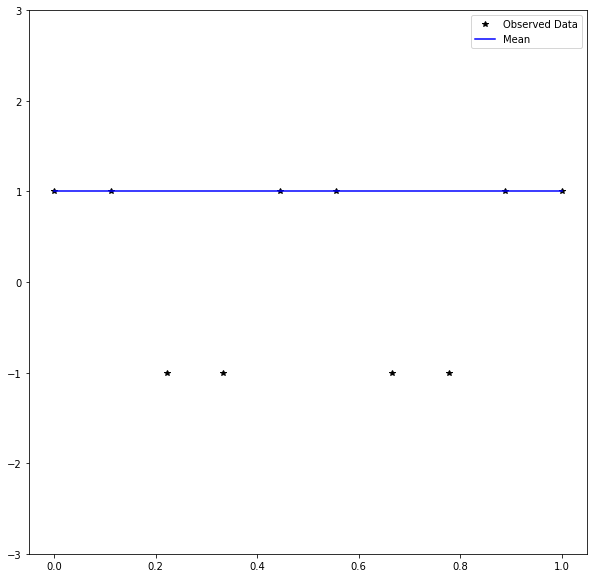

In [13]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float().mul(2).sub(1)
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])